# Constrained SciNet: mass-spring

## Set up

In [ ]:
! git clone https://github.com/gbarber94/ConSciNet

In [ ]:
% cd ConSciNet

In [15]:
import autograd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 

from models.conscinet import VAEncoder, MLP, HNN, ConSciNet #*
from utils.data_loader import load_data 
from utils.training import load_model
from utils.spring_system import *

## Load data

In [16]:
# load training data
system = 'spring' 
data = load_data(system = system, n_to_load = 5)
print(data.keys())

dict_keys(['x', 'aux_vars', 'qp_dot', 'q', 'p', 'qdot', 'pdot', 't_eval', 'k', 'm'])


In [17]:
# setup trial
np.random.seed(0)
n_level = 0.03
data = setup_trial(data.copy(), sigma = n_level)
data_in = data['data_in']

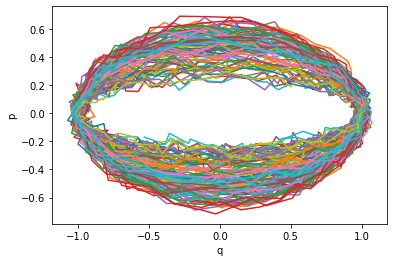

In [18]:
# plot noisy mass-spring data
for i in range(50):
  plt.plot(data['q_with_noies'][i],data['p_with_noies'][i])

plt.xlabel('q')
plt.ylabel('p');

In [19]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load training data
inputs  = torch.Tensor(data['data_in'])
outputs = torch.Tensor(data['qp_dot_with_noies'])

traindata  = TensorDataset(inputs, outputs)
dataloader = DataLoader(traindata, batch_size=256,shuffle=False, num_workers= 1) # 256

## Load models

In [20]:
# Initialize models

latent_dim = 3
aux_dim = 2

# Initialize a baseline SciNet model

encoder = VAEncoder(input_dim = 100, # input trajectory length 50
                    latent_dim = 3, # output latent vector z
                    layer_dim = [500,100]) # ae layer dimensions, same as in SciNet

# In the baseline we use a MLP as the neural analog function in our decoder
neural_analog_func_b = MLP(input_dim = latent_dim + aux_dim, # f(z,q,p)
                           hidden_dim   = 10, # layer dimensions
                           output_dim   = 2,  # output size 2 (qdot,pdot)
                           activation_func = nn.Tanh())

b_scinet_3lv03 = ConSciNet(Encoder = encoder, # VAE encoder
                     NAFunc = neural_analog_func_b, # MLP decoder
                     trial = f'Noise_lvl03_Baseline_{system}') # trial label


# Initialize a Constrained SciNet model

encoder = VAEncoder(input_dim = 100, # input trajectory length 50
                    latent_dim = latent_dim, # output latent vector z
                    layer_dim = [500,100]) # ae layer dimensions, same as in SciNet

diff_func = MLP(input_dim = latent_dim + aux_dim, # f(z,q,p)
                hidden_dim   = 10, # HNN layer dimensions
                output_dim   = 1,  # output size 1 H*
                activation_func = nn.Tanh())

# In the ConSciNet we use a modified HNN as the neural analog function in our decoder          
neural_analog_func = HNN(input_dim = 2, # number of canonical coordinates (q,p) input, the latent variables out put from the encoder are also received 
                         differentiable_model = diff_func
                         )

c_scinet_3lv03 = ConSciNet(Encoder = encoder, # VAE encoder
                     NAFunc = neural_analog_func, # HNN decoder
                     trial = f'Noise_lvl03_ConSciNet_{system}') # trial label

In [21]:
# load weights
load_model(c_scinet_3lv03,'models/weights/Noise_lvl03_ConSciNet_spring_weights50k_lv3.pt')
load_model(b_scinet_3lv03,'models/weights/Noise_lvl03_Baseline_spring_weights50k_lv3.pt')

<All keys matched successfully>

## Results

In [23]:
def get_lv(model, model_input):
    """
    Returns a vector of the latent variables for all input trajectories.
    Parameters:
    model: ConSciNet or Baseline model
    model_inputs: data_in
    """
    z_list = []
    z_dim = model.encoder.latent_dim

    [z_list.append([]) for i in range(z_dim)]

    for i in range(data['x'].shape[0]):
      m = model.encoder(torch.tensor(model_input[i][:-2]).float()) #.detach().numpy()[0]
      latent_vec = model.encoder.mu.detach().numpy()
      [z_list[i].append(latent_vec[i]) for i in range(z_dim)]
    return z_list


def integrate_model(model, t_span, y0, lv,**kwargs):
    """
    Evaluate a given model with an ODE solver
    Parameters:
    model: ConSciNet or Baseline model
    t_span: list of time interval [t_lower,t_upper]
    y0: y0
    lv: latent variables set to evaluate the decoder at
    """
      
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32) #.view(1,2)
        hnn_in = torch.cat([x.squeeze(),lv[0]])
        
        #[(latent,q,p), (q,p)]
        dx = model.nafunc.time_derivative(hnn_in,x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)



#### Phase predictions

In [24]:
def trj_pred(b_model,c_model, trial, model_input, t_span = [0,10], n_points = 2000, share_axis = True):
    """
    Generate trajectory predictions for a trial.
    Parameters:
    b_model: Baseline model
    c_model: ConSciNet model
    trial: trial number
    model_input: data
    t_span: list of time interval [t_lower,t_upper]
    n_points: number of points to evaulate
    share_axis: share plot axis
    """

    # get latent variables for input trial
    c_lv = c_model.encoder(torch.tensor(model_input['data_in'][trial][:-2]).float())
    b_lv = b_model.encoder(torch.tensor(model_input['data_in'][trial][:-2]).float())

    # ODE solver params
    y0 = [1,0]
    t_eval = np.linspace(t_span[0], t_span[1], n_points)
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}

    # integrate models and return predictions
    lv = c_lv
    c_path = integrate_model(c_model, t_span, y0, lv = c_lv, **kwargs)
    lv = b_lv
    b_path = integrate_model(b_model, t_span, y0,lv = b_lv, **kwargs)
    
    # plot predictions
    fig, axs = plt.subplots(1, 2,figsize=(10,4), sharey= share_axis, sharex= share_axis)

    axs[1].scatter(x = c_path['y'][0],y = c_path['y'][1], c = c_path['t'], cmap = 'plasma')
    c = axs[0].scatter(x = b_path['y'][0],y = b_path['y'][1], c = b_path['t'], cmap = 'plasma')

    axs[1].set_xlabel('q', fontsize = 12)
    axs[1].set_ylabel('p', fontsize = 12)
    axs[1].set_title('Constrained SciNet', fontsize = 15)
    axs[1].scatter(model_input['q_with_noies'][trial],model_input['p_with_noies'][trial], color = 'black', label = 'Ground truth')

    axs[0].set_xlabel('q', fontsize = 12)
    axs[0].set_ylabel('p', fontsize = 12)
    axs[0].set_title('Baseline SciNet', fontsize = 15);
    axs[0].scatter(model_input['q_with_noies'][trial],model_input['p_with_noies'][trial], color = 'black', label = 'Ground truth')

    fig.subplots_adjust(right=0.8, wspace = .3,top=0.8)
    k = np.round(model_input['k'][trial],3)
    m = np.round(model_input['m'][trial],3)
    sigma = model_input['n_level']
    fig.suptitle(f'Spring mass predictions: $\sigma = {sigma}$ | m = {m}, k = {k}',fontsize = 18);
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(c, cax=cbar_ax).set_label('time', fontsize = '12');

    return fig

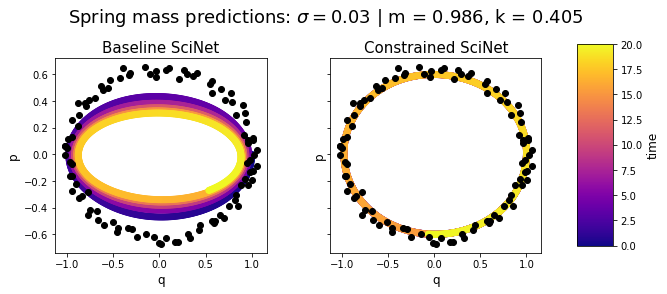

In [26]:
trial = 1 #np.random.randint(1,49000) # vary between [1,49000] to plot a different trial
t_span = [0,20]

fig = trj_pred(b_model = b_scinet_3lv03, c_model=c_scinet_3lv03,model_input = data, trial = trial, t_span = t_span, n_points = 2000)

### Latent variable disentanglement

In [27]:
# get the latent vector for each model, returns [z_1,z_2,z_3] for each input trajectory
c_latent_vec03 = get_lv(c_scinet_3lv03, model_input = data['data_in'])
b_latent_vec03 = get_lv(b_scinet_3lv03, model_input = data['data_in'])

In [28]:
def lv_plot(latent_vec, title, n = 3):
    """
    Plot latent variables against ground truth parameters
    Parameters:
    latent_vec: latent vector for a given model
    title: plot title
    n: number of latent variables
    """
    fmt = lambda x: "{:.2f}%".format(x)
    tick_marks = np.array([0.1,0.2,0.3,0.4,0.5])

    fig = plt.figure(figsize=(30,8))
    for i in range(n):
      ax = fig.add_subplot(1, n, 1+i, projection='3d')
      surf = ax.plot_trisurf(np.array(data['k'])[:1000], np.array(data['m'])[:1000], np.array(latent_vec[i])[:1000], cmap='viridis',
                            linewidth=0, antialiased=False, edgecolor='none')
      ax.set_title(f'latent variable: {i+1}', fontsize  = 15)
      ax.set_xlabel("k",fontsize  = 15)
      ax.set_ylabel("m", fontsize = 15)
      ax.set_zlabel(f"$z_{{{i+1}}}$ activation", fontsize = 15)
      ax.set_zlim(-0.3,0.3)
      ax.set_xticks(tick_marks)
    
    fig.set_size_inches(15, 5)
    plt.tight_layout()
    fig.suptitle(title,fontsize = 20);
    plt.subplots_adjust(top=0.9, wspace=0.2)
    
    #plt.savefig('Spring_Baseline_lv_NEW.svg', format='svg',bbox_inches='tight', dpi = 300)

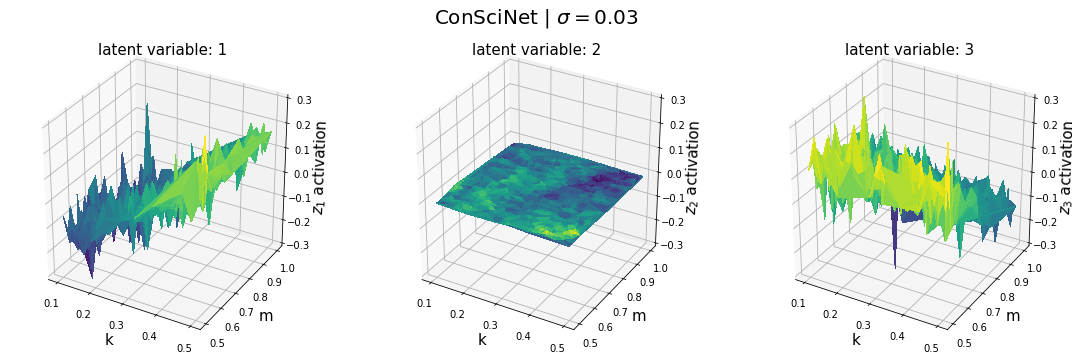

In [29]:
lv_plot(latent_vec = c_latent_vec03, title = f'ConSciNet | $\sigma = {n_level}$')

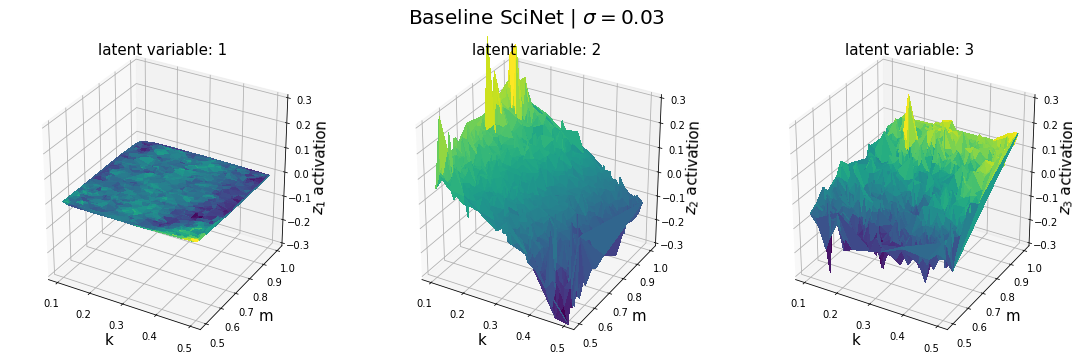

In [30]:
lv_plot(latent_vec = b_latent_vec03, title = f'Baseline SciNet | $\sigma = {n_level}$')

### Interpolation

In [35]:
def evaluate_model(latent_vec = None,
                   lv_pos_k = None,
                   lv_pos_m = None,                   
                   model = 'gt', 
                   data = data, 
                   n = 5, 
                   y0 = [1,0], 
                   t_span = [0,10], 
                   poly_order = 5):
    """
    Evaluate a model or ground truth at a number of interpolated latent variables.
    Parameters:
    latent_vec: latent variable vector obtained with get_lv()
    lv_pos_k: position of the latent variable encoding a k like value
    lv_pos_m: position of the latent variable encoding a m like value
    model: a ConSciNet or Baseline model or the string 'gt' for ground truth evaluation
    data: data
    n: number to interpolate
    y0: y0
    t_span: list of time interval [t_lower,t_upper]
    poly_order: order of polynomial to fit between the latent variable and ground truth parameters
    """
    
    # ODE args
    t_eval = np.linspace(t_span[0], t_span[1], 2000)
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}

    # ground truth eval
    if model == 'gt':

      k_vals = np.linspace(np.min(data['k']), np.max(data['k']),n_interp)
      m_vals = np.linspace(np.min(data['m']), np.max(data['m']),n_interp)
      t_eval = np.linspace(t_span[0], t_span[1], 2000)

      gt_eval_k = []
      y0 = [1,0]
      for k in k_vals:
        spring_params['k'] = k
        spring_params['m'] = 0.75
        gt_path = solve_ivp(fun=dynamics_fn, 
                                t_span=t_span, 
                                y0=y0, 
                                t_eval=t_eval, 
                                rtol=1e-12)
        gt_eval_k.append(gt_path)

      gt_eval_m = []
      for m in m_vals:
        spring_params['k'] = 0.25
        spring_params['m'] = m
        gt_path2 = solve_ivp(fun=dynamics_fn, 
                                t_span=t_span, 
                                y0=y0, 
                                t_eval=t_eval, 
                                rtol=1e-12)
        gt_eval_m.append(gt_path2)

      return gt_eval_k, gt_eval_m
    
    # model prediction
    f_k =  np.poly1d(np.polyfit(data['k'],latent_vec[lv_pos_k], deg = poly_order))
    f_m =  np.poly1d(np.polyfit(data['m'],latent_vec[lv_pos_m], deg = poly_order))

    n = 4
    k_vals = np.linspace(np.min(data['k']), np.max(data['k']),n)
    m_vals = np.linspace(np.min(data['m']), np.max(data['m']),n)

    k_like_vals = f_k(k_vals)
    m_like_vals = f_m(m_vals)

    pred_k = []
    for lv in k_like_vals:
      pred = []
      lv_values = np.zeros(3)
      lv_values[lv_pos_k] = lv
      lv_values[lv_pos_m] = f_m(0.75) #m_like_vals[0]
      #lv_values = [0,lv,0]
      lv_values = list(lv_values)
      lv = torch.tensor([lv_values]).float()
      #print(lv)
      pred_k.append(integrate_model(model, t_span, y0,lv = lv, **kwargs))

    pred_m = []
    for i in m_like_vals:
      pred = []
      lv_values = np.zeros(3)
      lv_values[lv_pos_m] = i
      lv_values[lv_pos_k] = f_k(0.25)
      lv_values = list(lv_values)
      lv = torch.tensor([lv_values]).float()
      pred_m.append(integrate_model(model, t_span, y0, lv = lv, **kwargs))

    return pred_k, pred_m


In [36]:
# evaluate models over t-span = [0,20]

n_interp = 4
t_span = [0,20]
poly_order = 5

lv_pos_k = 1 # index from 0
lv_pos_m = 2

baseline_eval_k, baseline_eval_m  = evaluate_model(latent_vec = b_latent_vec03,
                                                    lv_pos_k = lv_pos_k,
                                                    lv_pos_m = lv_pos_m,
                                                    model = b_scinet_3lv03, 
                                                    data = data, 
                                                    n = n_interp, 
                                                    y0 = [1,0], 
                                                    t_span = t_span, 
                                                    poly_order = poly_order)


lv_pos_k = 0
lv_pos_m = 2

conscinet_eval_k, conscinet_eval_m = evaluate_model(latent_vec = c_latent_vec03,
                                                    lv_pos_k = lv_pos_k,
                                                    lv_pos_m = lv_pos_m,
                                                    model = c_scinet_3lv03, 
                                                    data = data, 
                                                    n = n_interp, 
                                                    y0 = [1,0], 
                                                    t_span = t_span, 
                                                    poly_order = poly_order)

gt_eval_k, gt_eval_m = evaluate_model(model ='gt', 
                                      data = data, 
                                      n = n_interp, 
                                      y0 = [1,0], 
                                      t_span = t_span)



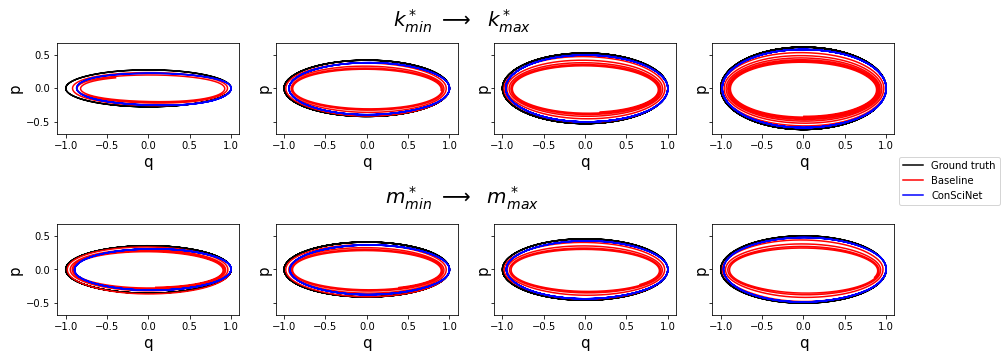

In [37]:
# phase plots

fig, axs = plt.subplots(2, n_interp,figsize=(15,5), sharey=True)
for i in range(n_interp):
  axs[0, i].plot(gt_eval_k[i]['y'][0],gt_eval_k[i]['y'][1], color = 'black', label = 'Ground truth')
  axs[0, i].plot(baseline_eval_k[i]['y'][0],baseline_eval_k[i]['y'][1], color = 'red', label = 'Baseline')
  axs[0, i].plot(conscinet_eval_k[i]['y'][0],conscinet_eval_k[i]['y'][1], color = 'blue', label = 'ConSciNet')
  
  axs[1, i].plot(gt_eval_m[i]['y'][0],gt_eval_m[i]['y'][1], color = 'black', label = 'Ground truth')
  axs[1, i].plot(baseline_eval_m[i]['y'][0],baseline_eval_m[i]['y'][1], color = 'red', label = 'Baseline')
  axs[1, i].plot(conscinet_eval_m[i]['y'][0],conscinet_eval_m[i]['y'][1], color = 'blue', label = 'ConSciNet')
  
  axs[0,i].set_ylabel('p', fontsize = 15)
  axs[0,i].set_xlabel('q', fontsize = 15)
  axs[1,i].set_ylabel('p', fontsize = 15)
  axs[1,i].set_xlabel('q', fontsize = 15)
  
fig.suptitle('$k_{min}^*$ $\longrightarrow$  $k_{max}^*$',fontsize = 20);
plt.legend(loc="upper left", bbox_to_anchor=(1,1.8))

# 2nd row title
plt.subplots_adjust(hspace=1)
plt.figtext(0.5, 0.45, '$m_{min}^*$ $\longrightarrow$  $m_{max}^*$', ha='center', va='center', fontsize = 20);

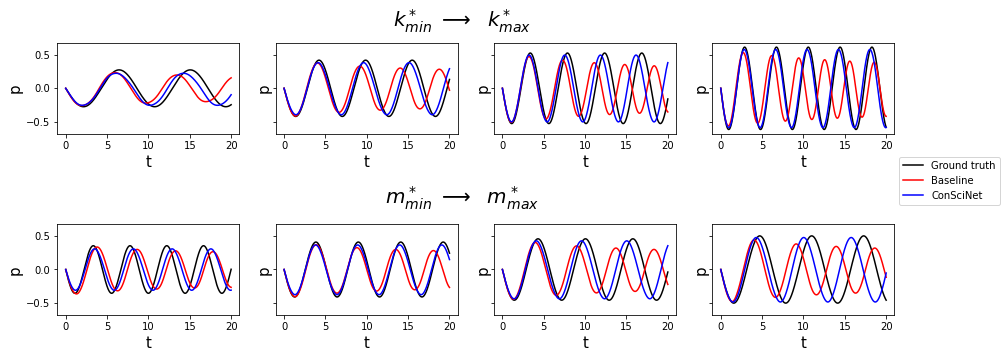

In [38]:
# time plots

p_or_q  = 'p' # plot either momentum p or position 'q'

coord_keys = {'q': 0,
              'p': 1}

coord = coord_keys[p_or_q]

t_plot = np.linspace(t_span[0],t_span[1],gt_eval_k[i]['y'].shape[1])

fig, axs = plt.subplots(2, n_interp,figsize=(15,5), sharey=True)
for i in range(n_interp):
  axs[0, i].plot(t_plot, gt_eval_k[i]['y'][coord], color = 'black', label = 'Ground truth')
  axs[0, i].plot(t_plot, baseline_eval_k[i]['y'][coord], color = 'red', label = 'Baseline')
  axs[0, i].plot(t_plot, conscinet_eval_k[i]['y'][coord], color = 'blue', label = 'ConSciNet')
  
  axs[1, i].plot(t_plot, gt_eval_m[i]['y'][coord], color = 'black', label = 'Ground truth')
  axs[1, i].plot(t_plot, baseline_eval_m[i]['y'][coord], color = 'red', label = 'Baseline')
  axs[1, i].plot(t_plot, conscinet_eval_m[i]['y'][coord], color = 'blue', label = 'ConSciNet')
  
  axs[0,i].set_ylabel(p_or_q, fontsize = 15)
  axs[0,i].set_xlabel('t', fontsize = 15)
  axs[1,i].set_ylabel(p_or_q, fontsize = 15)
  axs[1,i].set_xlabel('t', fontsize = 15)
  
fig.suptitle('$k_{min}^*$ $\longrightarrow$  $k_{max}^*$',fontsize = 20);
plt.legend(loc="upper left", bbox_to_anchor=(1,1.8))

# 2nd row title
plt.subplots_adjust(hspace=1)
plt.figtext(0.5, 0.45, '$m_{min}^*$ $\longrightarrow$  $m_{max}^*$', ha='center', va='center', fontsize = 20);

### MSE

In [39]:
n_interp = 4
import pandas as pd
conscinet_mse = [np.mean(np.square(gt_eval_k[i]['y'] - conscinet_eval_k[i]['y'])) for i in range(n_interp)]
baseline_mse =  [np.mean(np.square(gt_eval_k[i]['y'] - baseline_eval_k[i]['y']))  for i in range(n_interp)]

k_vals = np.round(np.linspace(0.1, 0.5, n_interp),1)
mse_df = pd.DataFrame()
mse_df['spring coefficient'] = k_vals
mse_df['Baseline MSE'] = baseline_mse
mse_df['ConSciNet MSE'] = conscinet_mse
mse_df
#mse_df.to_latex()

,spring coefficient,Baseline MSE,ConSciNet MSE
0,0.1,0.206873,0.048072
1,0.2,0.336666,0.025237
2,0.4,0.491438,0.128205
3,0.5,0.485663,0.020516


In [40]:
n_interp = 4
import pandas as pd
conscinet_mse = [np.mean(np.square(gt_eval_m[i]['y'][0] - conscinet_eval_m[i]['y'][0])) for i in range(n_interp)]
baseline_mse =  [np.mean(np.square(gt_eval_m[i]['y'][0] - baseline_eval_m[i]['y'][0]))  for i in range(n_interp)]

m_vals = np.round(np.linspace(0.5, 1, n_interp),1)
mse_df = pd.DataFrame()
mse_df['mass'] = m_vals
mse_df['Baseline MSE'] = baseline_mse
mse_df['ConSciNet MSE'] = conscinet_mse
mse_df
#mse_df.to_latex()
#

,mass,Baseline MSE,ConSciNet MSE
0,0.5,0.647612,0.318128
1,0.7,0.204427,0.009679
2,0.8,0.845454,0.157526
3,1.0,0.913107,0.517312
